In [1]:
def cal_distance(x1, y1, x2, y2):
    '''calculate the Euclidean distance'''
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

In [2]:
def get_boundary(vertices):
    '''get the tight boundary around given vertices
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        the boundary
    '''
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    x_min = min(x1, x2, x3, x4)
    x_max = max(x1, x2, x3, x4)
    y_min = min(y1, y2, y3, y4)
    y_max = max(y1, y2, y3, y4)
    return x_min, x_max, y_min, y_max

In [3]:
def cal_error(vertices):
    '''default orientation is x1y1 : left-top, x2y2 : right-top, x3y3 : right-bot, x4y4 : left-bot
    calculate the difference between the vertices orientation and default orientation
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        err     : difference measure
    '''
    x_min, x_max, y_min, y_max = get_boundary(vertices)
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    err = cal_distance(x1, y1, x_min, y_min) + cal_distance(x2, y2, x_max, y_min) + \
          cal_distance(x3, y3, x_max, y_max) + cal_distance(x4, y4, x_min, y_max)
    return err

In [4]:
def get_rotate_mat(theta):
    '''positive theta value means rotate clockwise'''
    return np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])

In [9]:
def rotate_vertices(vertices, theta, anchor=None):
    '''rotate vertices around anchor
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        theta   : angle in radian measure
        anchor  : fixed position during rotation
    Output:
        rotated vertices <numpy.ndarray, (8,)>
    '''
    v = vertices.reshape((4, 2)).T
    if anchor is None:
        anchor = v[:, :1]
        anchor = np.array([[v[0].sum()],[v[1].sum()]])/4
#     print(v)
#     print(anchor)
    rotate_mat = get_rotate_mat(theta)
    res = np.dot(rotate_mat, v - anchor)
    return (res + anchor).T.reshape(-1)

In [10]:
def find_min_rect_angle(vertices):
    '''find the best angle to rotate poly and obtain min rectangle
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        the best angle <radian measure>
    '''
    angle_interval = 1
    angle_list = list(range(-90, 90, angle_interval))
    area_list = []
    for theta in angle_list:
        rotated = rotate_vertices(vertices, theta / 180 * math.pi)
        x1, y1, x2, y2, x3, y3, x4, y4 = rotated
        temp_area = (max(x1, x2, x3, x4) - min(x1, x2, x3, x4)) * \
                    (max(y1, y2, y3, y4) - min(y1, y2, y3, y4))
        area_list.append(temp_area)

    sorted_area_index = sorted(list(range(len(area_list))), key=lambda k: area_list[k])
    min_error = float('inf')
    best_index = -1
    rank_num = 10
    # find the best angle with correct orientation
    for index in sorted_area_index[:rank_num]:
        rotated = rotate_vertices(vertices, angle_list[index] / 180 * math.pi)
        temp_error = cal_error(rotated)
        if temp_error < min_error:
            min_error = temp_error
            best_index = index
    return angle_list[best_index] / 180 * math.pi

1
-1


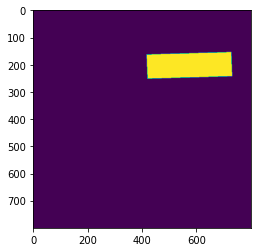

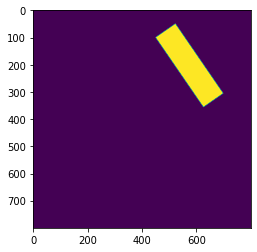

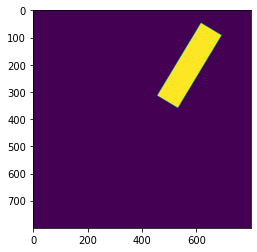

In [15]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import math

box = [377,117,463,117,465,130,378,130]
box1 = np.array([420,251,726,236,727,154,421,163])
mask = np.zeros((800, 800), np.float32)
# poly = np.around(np.array(box).reshape((4, 2))).astype(np.int32)
# cv2.fillPoly(mask, [poly], 255)

box1 = cv2.minAreaRect(box1.reshape((4, 2)))
# 获取矩形四个顶点，浮点型
box1 = cv2.boxPoints(box1).reshape((-1))
# print(box1)

# print(box1[::2].sum()/4)
# print(box1[1::2].sum()/4)
theta = find_min_rect_angle(box1)
# print(theta)
rotate_mat = get_rotate_mat(theta)
# anchor = np.array([box1[::2].sum()/4,box1[1::2].sum()/4])

theta=1
print(theta)
rotated_vertices = rotate_vertices(box1, theta)
x_min, x_max, y_min, y_max = get_boundary(rotated_vertices)
# print(x_min, x_max, y_min, y_max)

# print(rotated_vertices[::2].sum()/4)
# print(rotated_vertices[1::2].sum()/4)

theta=-1
print(theta)
rotated_vertices1 = rotate_vertices(box1, theta)
x_min, x_max, y_min, y_max = get_boundary(rotated_vertices)

mask2 = np.zeros((800, 800), np.float32)
poly = np.around(np.array(rotated_vertices1).reshape((4, 2))).astype(np.int32)
cv2.fillPoly(mask2, [poly], 255)

mask1 = np.zeros((800, 800), np.float32)
poly = np.around(np.array(rotated_vertices).reshape((4, 2))).astype(np.int32)
cv2.fillPoly(mask1, [poly], 255)
# print(mask1.sum()/255)
# print(rotated_vertices)

poly = np.around(np.array(box1).reshape((4, 2))).astype(np.int32)
cv2.fillPoly(mask, [poly], 255)

# print(mask.sum()/255)
plt.imshow(mask)
plt.show()

plt.imshow(mask1)
plt.show()

plt.imshow(mask2)
plt.show()